In [0]:
#!pip install tensorflow

     |████████████████████████████████| 86.3MB 3.5MB/s eta 0:00:01
     |████████████████████████████████| 1.3MB 74.3MB/s eta 0:00:01
     |████████████████████████████████| 3.8MB 67.6MB/s eta 0:00:01
     |████████████████████████████████| 61kB 35.6MB/s eta 0:00:01
     |████████████████████████████████| 450kB 61.9MB/s eta 0:00:01
     |████████████████████████████████| 51kB 30.7MB/s eta 0:00:01
     |████████████████████████████████| 112kB 71.6MB/s eta 0:00:01
     |████████████████████████████████| 71kB 36.4MB/s eta 0:00:01
     |████████████████████████████████| 2.3MB 62.7MB/s eta 0:00:01
     |████████████████████████████████| 51kB 33.1MB/s eta 0:00:01
     |████████████████████████████████| 92kB 37.0MB/s eta 0:00:01
     |████████████████████████████████| 2.9MB 71.9MB/s eta 0:00:01
  Stored in directory: /root/.cache/pip/wheels/a7/15/a0/0a0561549ad11cdc1bc8fa1191a353efd30facf6bfb507aefc
  Stored in directory: /root/.cache/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5b

# Loading balanced data

In this notebook we will try to build simple DL model based on CNN or/and LSTM for text classification. The focus of the blog post is to compare simple models (TF-IDF+simple ml model) with more recent advanced models in NLP (ULMFIT in our case). 
The explained approaches in this notebook are outside the scope and we will simply show how to prepare/train models without going deeper into finetuning the parameters. 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string 
import warnings 
import seaborn as sns 
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
PATH = "/app/analyse/"

import pandas as pd
# load data from feather file

data = pd.read_feather(f'{PATH}/data/dataset_processed_balanced')

In [0]:
data.tail()

,index,text,clean_text,category
34131,126765,Lady Gaga Has Nothing On These Bizarre Marine ...,lady gaga bizarre marine worm marine zoologist...,ENVIRONMENT
34132,151131,U.S. Wildfire Interactive Shows Rising Tempera...,wildfire interactive show rise temperature sno...,ENVIRONMENT
34133,176713,Clean Energy Investment Slows Amid Uncertainty...,clean energy investment slow amid uncertainty ...,ENVIRONMENT
34134,196290,Brazil Navy: Oil Stain Spotted In Chevron Fiel...,brazil navy oil stain spot chevron field compa...,ENVIRONMENT
34135,152383,Baby Gorilla Twins Have An Adorable Playdate I...,baby gorilla twin adorable playdate rwanda vol...,ENVIRONMENT


In [0]:
data.shape

(34136, 4)

We will split data and keep 10% for testing set.  This set will not be seen during the training and will be used for evaluation purpose. The same split will be used in ULMFIT model (so results are comparable). 

In [0]:
xtrain, xtest, ytrain, ytest = train_test_split(data['clean_text'], data.category, random_state=42,test_size=0.1)

# Pre-processing

- Processing the text

We will use the 'cleaned text' generated in previous notebook (by Spacy). Keras Tokenizer allows to convert words . into indices (for example here we choosed 25000 most frequent words).

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_NB_WORDS = 25000

# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(xtrain)
sequences = tokenizer.texts_to_sequences(xtrain)
sequences_test = tokenizer.texts_to_sequences(xtest)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 29918 unique tokens.


In [0]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 15.5
max length: 114


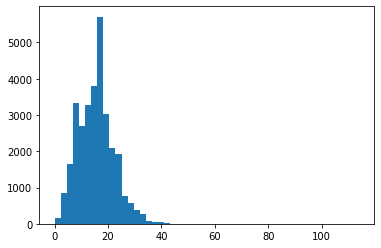

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

We observe that most sequences have a length smaller than 40 tokens.

- Padding

As illustarted in previous plot, the sequences for each observation in the training dataset have different lengths. To be abble to apply embedding, we need to truncate and pad the tokenized sequences.

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


MAX_SEQUENCE_LENGTH = 50

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (30722, 50)
Shape of data test tensor: (3414, 50)


- Labels encoding

An important step is to encode (one-hot encoding representation) of labels before using them in a DL model. First we transform labels into indices, then we use `to_categorical` to obtain the one-hot encoding.

In [0]:
# Labels encoding 

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(ytrain)

ytrain = le.transform(ytrain)
ytest = le.transform(ytest)

In [0]:
# Targets are saved in the LabelEncoder
target_names = le.classes_
print(target_names)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


In [0]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(ytrain)
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (30722, 34)


# Building DL model for text classification

Now we have prepared datasets in the desired format by TF-keras. We can start building (cooking) Deep Learning models. 
We will use Embedding layer to get a continuous repersentation of tokens. 

The First model consist on: 

- Embedding to get a vector representation for each word (token).
- Average all words in a sequence
- Add a dense layer to output N_CLASSES (+ softmax)

In [0]:
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

EMBEDDING_DIM = 50
N_CLASSES = len(target_names)

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

es = EarlyStopping(monitor='val_acc', restore_best_weights=True)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001), metrics=['acc', 'top_k_categorical_accuracy'],
              callbacks=[es])


In [0]:
model.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 50, 50)            1250000   
_________________________________________________________________
global_average_pooling1d_5 ( (None, 50)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 34)                1734      
Total params: 1,251,734
Trainable params: 1,251,734
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Train on 24577 samples, validate on 6145 samples
Epoch 1/10
24577/24577 [==============================] - 7s 270us/sample - loss: 3.4891 - acc: 0.1208 - top_k_categorical_accuracy: 0.3535 - val_loss: 3.4066 - val_acc: 0.3074 - val_top_k_categorical_accuracy: 0.5639
Epoch 2/10
24577/24577 [==============================] - 6s 253us/sample - loss: 3.1840 - acc: 0.3839 - top_k_categorical_accuracy: 0.6988 - val_loss: 2.9800 - val_acc: 0.4042 - val_top_k_categorical_accuracy: 0.7198
Epoch 3/10
24577/24577 [==============================] - 6s 253us/sample - loss: 2.6658 - acc: 0.5024 - top_k_categorical_accuracy: 0.8098 - val_loss: 2.5626 - val_acc: 0.4527 - val_top_k_categorical_accuracy: 0.7590
Epoch 4/10
24577/24577 [==============================] - 6s 253us/sample - loss: 2.2224 - acc: 0.5651 - top_k_categorical_accuracy: 0.8533 - val_loss: 2.2808 - val_acc: 0.4786 - val_top_k_categorical_accuracy: 0.7884
Epoch 5/10
24577/24577 [==============================] - 6s 254us/sample - los

We can compute the accuracy on the test dataset as follows

In [0]:
output_test = model(x_test)
test_casses = np.argmax(output_test, axis=-1)
print("Test accuracy:", np.mean(test_casses == ytest))


Test accuracy: 0.526654950205038


The performance is comparable to a finetuned TF-IDF+Logistic-regression (see Github repo logs folder for results of simple models).

## More complex model 

Maybe a more complex model can lear better on our dataset. Let us try the following cnn1d model. 

In [0]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# A 1D convolution with 128 output channels
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = Dropout(0.3)(x)
# MaxPool divides the length of the sequence by *
x = MaxPooling1D(5)(x)
# A 1D convolution with 64 output channels
x = Conv1D(64, 5, activation='relu')(x)
x = Dropout(0.3)(x)
# MaxPool divides the length of the sequence by *
x = MaxPooling1D(5)(x)
x = Flatten()(x)

predictions = Dense(N_CLASSES, activation='softmax')(x)

es = EarlyStopping(monitor='val_acc', restore_best_weights=True)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001), metrics=['acc', 'top_k_categorical_accuracy'],
              callbacks=[es])


In [0]:
model.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 50, 50)            1250000   
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 46, 128)           32128     
_________________________________________________________________
dropout_50 (Dropout)         (None, 46, 128)           0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 9, 128)            0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5, 64)             41024     
_________________________________________________________________
dropout_51 (Dropout)         (None, 5, 64)             0  

In [0]:
model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Train on 24577 samples, validate on 6145 samples
Epoch 1/10
24577/24577 [==============================] - 10s 403us/sample - loss: 2.6360 - acc: 0.3373 - top_k_categorical_accuracy: 0.6308 - val_loss: 2.4118 - val_acc: 0.4627 - val_top_k_categorical_accuracy: 0.7647
Epoch 2/10
24577/24577 [==============================] - 10s 392us/sample - loss: 1.5713 - acc: 0.5835 - top_k_categorical_accuracy: 0.8770 - val_loss: 2.0475 - val_acc: 0.4921 - val_top_k_categorical_accuracy: 0.7950
Epoch 3/10
24577/24577 [==============================] - 9s 385us/sample - loss: 1.3143 - acc: 0.6370 - top_k_categorical_accuracy: 0.9051 - val_loss: 1.9351 - val_acc: 0.5063 - val_top_k_categorical_accuracy: 0.8068
Epoch 4/10
24577/24577 [==============================] - 9s 376us/sample - loss: 1.1873 - acc: 0.6695 - top_k_categorical_accuracy: 0.9189 - val_loss: 1.8846 - val_acc: 0.5116 - val_top_k_categorical_accuracy: 0.8088
Epoch 5/10
24577/24577 [==============================] - 9s 380us/sample - l

In [0]:
output_test = model(x_test)
test_casses = np.argmax(output_test, axis=-1)
print("Test accuracy:", np.mean(test_casses == ytest))


Test accuracy: 0.520796719390744


## LSTM model

Recurrent neural networks through LSTM (or GRU) are a powerful tool for sequence modeling. In the following cell we will try to build s imple model based on LSTM/CNN and check its performance on the hold-out dataset.

In [0]:
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
x = Dropout(0.3)(x)

# MaxPool divides the length of the sequence by *
x = MaxPooling1D(5)(x)
x = Conv1D(64, 5)(x)
x = Dropout(0.3)(x)

x = MaxPooling1D(5)(x)

# LSTM layer with a hidden size of 64
x = LSTM(64)(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)

model = Model(sequence_input, predictions)

es = EarlyStopping(monitor='val_acc', restore_best_weights=True)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001), metrics=['acc', 'top_k_categorical_accuracy'],  callbacks=[es])

In [0]:
model.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 50, 50)            1250000   
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 46, 64)            16064     
_________________________________________________________________
dropout_52 (Dropout)         (None, 46, 64)            0         
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 9, 64)             0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 5, 64)             20544     
_________________________________________________________________
dropout_53 (Dropout)         (None, 5, 64)             0  

In [0]:
model.fit(x_train, y_train, validation_split=0.2,
          epochs=20, batch_size=64)

Train on 24577 samples, validate on 6145 samples
Epoch 1/20
24577/24577 [==============================] - 7s 287us/sample - loss: 3.2593 - acc: 0.1822 - top_k_categorical_accuracy: 0.4619 - val_loss: 2.9761 - val_acc: 0.3077 - val_top_k_categorical_accuracy: 0.6404
Epoch 2/20
24577/24577 [==============================] - 5s 216us/sample - loss: 2.3155 - acc: 0.4451 - top_k_categorical_accuracy: 0.7855 - val_loss: 2.4113 - val_acc: 0.4314 - val_top_k_categorical_accuracy: 0.7408
Epoch 3/20
24577/24577 [==============================] - 5s 218us/sample - loss: 1.8421 - acc: 0.5537 - top_k_categorical_accuracy: 0.8560 - val_loss: 2.1731 - val_acc: 0.4666 - val_top_k_categorical_accuracy: 0.7655
Epoch 4/20
24577/24577 [==============================] - 5s 216us/sample - loss: 1.6142 - acc: 0.5973 - top_k_categorical_accuracy: 0.8827 - val_loss: 2.0436 - val_acc: 0.4869 - val_top_k_categorical_accuracy: 0.7774
Epoch 5/20
24577/24577 [==============================] - 5s 220us/sample - los

In [0]:
output_test = model(x_test)
test_casses = np.argmax(output_test, axis=-1)
print("Test accuracy:", np.mean(test_casses == ytest))


Test accuracy: 0.5175746924428822


---

*NB:*  This notebook was adapted from my Deep Learning class at the MSc of Data Science. Check out their Github repo, it has one of the best Deep Learning classes : https://github.com/m2dsupsdlclass/lectures-labs